# Spectral Clustering: Theory and Implementation

## Overview

Spectral clustering is a powerful technique that uses the eigenvalues and eigenvectors of matrices derived from the data to perform dimensionality reduction before clustering. Unlike traditional clustering methods like k-means, spectral clustering can identify clusters with non-convex boundaries and complex shapes.

### Key Advantages:
- **Handles non-linear boundaries**: Can separate interleaving crescents, concentric circles, and other complex patterns
- **Graph-based approach**: Views data as a graph where similar points are connected
- **Solid theoretical foundation**: Based on spectral graph theory and linear algebra
- **Effective dimensionality reduction**: Projects data to a space where clusters are more separable

### When to Use Spectral Clustering:
- Data has complex, non-convex cluster shapes
- Traditional methods (k-means) fail to separate the clusters
- You have a similarity/affinity measure between data points
- Number of clusters is relatively small (computational complexity increases with k)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import sys
sys.path.append('src/')

from spectral_clustering import spectral_clustering_k2
from compute_adjacency_matrix import compute_adjacency_matrix
from data import make_circles, make_moons
from main import visualize_spectral_clustering, compare_parameters, plot_spectral_clustering_results

np.random.seed(42)

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Mathematical Foundations

### 1. Graph Representation

Given a dataset $X = \{x_1, x_2, ..., x_n\}$ where $x_i \in \mathbb{R}^d$, we construct a weighted graph $G = (V, E)$ where:
- Vertices $V$ represent data points
- Edges $E$ connect similar points with weights $w_{ij}$

### 2. Eigenvalue Decomposition of Real Symmetric Matrices

Before diving into graph Laplacians, let's review the spectral decomposition of real symmetric matrices, which is fundamental to spectral clustering.

For a real symmetric matrix $M \in \mathbb{R}^{n \times n}$:

**Key Properties:**
- All eigenvalues $\lambda_i$ are real
- Eigenvectors corresponding to distinct eigenvalues are orthogonal
- $M$ can be diagonalized by an orthogonal matrix

**Spectral Decomposition:**
$$M = Q\Lambda Q^T$$

where:
- $Q = [v_1, v_2, ..., v_n]$ is an orthogonal matrix of eigenvectors
- $\Lambda = \text{diag}(\lambda_1, \lambda_2, ..., \lambda_n)$ is a diagonal matrix of eigenvalues
- $Q^T Q = QQ^T = I$ (orthogonality)

**Eigenvalue Ordering:**
We typically order eigenvalues as $\lambda_1 \leq \lambda_2 \leq ... \leq \lambda_n$

**Quadratic Forms:**
For any vector $x \in \mathbb{R}^n$:
$$x^T M x = \sum_{i=1}^n \lambda_i (x^T v_i)^2$$

This shows that the quadratic form is a weighted sum of the squared projections onto eigenvectors.

### 3. Adjacency Matrix

The adjacency matrix $A \in \mathbb{R}^{n \times n}$ encodes the similarity between points:

$$A_{ij} = \begin{cases}
1 & \text{if } x_j \in \text{k-nearest neighbors of } x_i \\
0 & \text{otherwise}
\end{cases}$$

We make $A$ symmetric: $A = \max(A, A^T)$

### 4. Degree Matrix

The degree matrix $D$ is a diagonal matrix where:
$$D_{ii} = \sum_{j=1}^{n} A_{ij}$$

This represents the total weight of edges connected to vertex $i$.

### 5. Graph Laplacian

There are two main variants:

**Unnormalized Laplacian:**
$$L = D - A$$

**Normalized Laplacian:**
$$L_{norm} = I - D^{-1/2}AD^{-1/2}$$

**Important:** Both Laplacians are real symmetric matrices, guaranteeing:
- Real eigenvalues
- Orthogonal eigenvectors
- Positive semi-definiteness (all $\lambda_i \geq 0$)

### 6. The Fiedler Vector

The Fiedler vector provides the optimal way to partition a graph into two parts. For an undirected graph $G$, it is found via the optimization problem:

$$\vec{F} = \arg\min_{\vec{x}} \vec{x}^T L \vec{x}$$

subject to the constraints:
- $\|\vec{x}\|_2 = 1$ (unit norm)
- $\vec{x} \perp \mathbf{1}$ (orthogonal to the constant vector)

**Rayleigh-Ritz Theorem**: The solution to this optimization problem is:

$$\vec{F} = \frac{\vec{v}_2}{\|\vec{v}_2\|}$$

where $\vec{v}_2$ is the eigenvector corresponding to the second smallest eigenvalue of $L$ (the first nonzero eigenvalue).

This optimization minimizes the "cut" between partitions while maintaining balance, making it ideal for clustering.

### 7. Key Properties

- **Symmetric and positive semi-definite**: All eigenvalues $\lambda_i \geq 0$
- **Smallest eigenvalue**: $\lambda_1 = 0$ with eigenvector $\mathbf{1}$ (vector of ones)
- **Fiedler value**: The second smallest eigenvalue $\lambda_2$ measures graph connectivity
- **Number of connected components**: Equal to the multiplicity of eigenvalue 0

### 8. The Clustering Insight

The key insight is that the eigenvectors of the Laplacian encode cluster information:
- For well-separated clusters, there's a significant gap between $\lambda_k$ and $\lambda_{k+1}$ (spectral gap)
- The first $k$ eigenvectors provide an embedding where clusters are more separable
- In the embedded space, simple algorithms like k-means work effectively

### Understanding the Optimization

The visualization above demonstrates three key aspects:

1. **Optimality**: Among all unit vectors orthogonal to the constant vector, the Fiedler vector achieves the minimum value of $\vec{x}^T L \vec{x}$

2. **Graph Cut Interpretation**: The quadratic form $\vec{x}^T L \vec{x} = \sum_{(i,j) \in E} w_{ij}(x_i - x_j)^2$ measures the "smoothness" of vector $\vec{x}$ over the graph. The Fiedler vector is the smoothest non-constant vector.

3. **Balanced Partition**: The Fiedler vector naturally separates the graph into two balanced parts, with positive values indicating one cluster and negative values the other.

## The Spectral Clustering Algorithm

### Algorithm for k=2 clusters:

1. **Input**: Data points $X \in \mathbb{R}^{n \times d}$, number of neighbors $k$

2. **Construct Similarity Graph**:
   - Compute k-nearest neighbors for each point
   - Build adjacency matrix $A$
   - Make it symmetric: $A = \max(A, A^T)$

3. **Compute Graph Laplacian**:
   - Calculate degree matrix: $D_{ii} = \sum_j A_{ij}$
   - For normalized: $L_{norm} = I - D^{-1/2}AD^{-1/2}$
   - For unnormalized: $L = D - A$

4. **Eigendecomposition**:
   - Compute eigenvalues and eigenvectors of $L$
   - Sort by eigenvalue magnitude
   - Extract Fiedler vector (2nd eigenvector)

5. **Cluster Assignment**:
   - Use the Fiedler vector $v_2$ to partition data
   - Common approach: median split
   - Assign: $y_i = \begin{cases} 0 & \text{if } v_{2,i} < \text{median}(v_2) \\ 1 & \text{otherwise} \end{cases}$

### Extension to k > 2 clusters:

For k clusters, use the first k eigenvectors as a new representation and apply k-means clustering in this embedded space.

## Implementation Details

Let's walk through the key components of our implementation:

In [6]:
import inspect

print("=" * 80)
print("SPECTRAL CLUSTERING IMPLEMENTATION")
print("=" * 80)
print(inspect.getsource(spectral_clustering_k2))

SPECTRAL CLUSTERING IMPLEMENTATION
def spectral_clustering_k2(X, n_neighbors=5, use_normalized_laplacian=True):
    """
    Manual implementation of spectral clustering for k=2 clusters.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Input data
    n_neighbors : int
        Number of nearest neighbors for adjacency matrix
    use_normalized_laplacian : bool
        Whether to use normalized vs unnormalized Laplacian

    Returns
    -------
    clusters : array of shape (n_samples,)
        Binary cluster assignments (0 or 1)
    eigenvector : array of shape (n_samples,)
        The Fiedler vector used for clustering
    eigenvalue : float
        The Fiedler value (2nd smallest eigenvalue)
    """
    # Step 1: Construct adjacency matrix
    A = compute_adjacency_matrix(X, n_neighbors)

    # Step 2: Compute degree matrix
    degrees = np.sum(A, axis=1)
    D = np.diag(degrees)

    # Step 3: Construct graph Laplacian
    if use_normalized_l

### Key Implementation Points:

1. **Adjacency Matrix Construction**: Uses k-nearest neighbors with symmetrization
2. **Degree Matrix Handling**: Special care for zero-degree nodes (isolated points)
3. **Eigendecomposition**: Uses `np.linalg.eigh` for symmetric matrices (more efficient and stable)
4. **Clustering Decision**: Median split is more robust than zero threshold
5. **Return Values**: Provides clusters, Fiedler vector, and eigenvalue for analysis

## Demonstration: Concentric Circles

Let's see spectral clustering in action with a classic example where k-means fails:

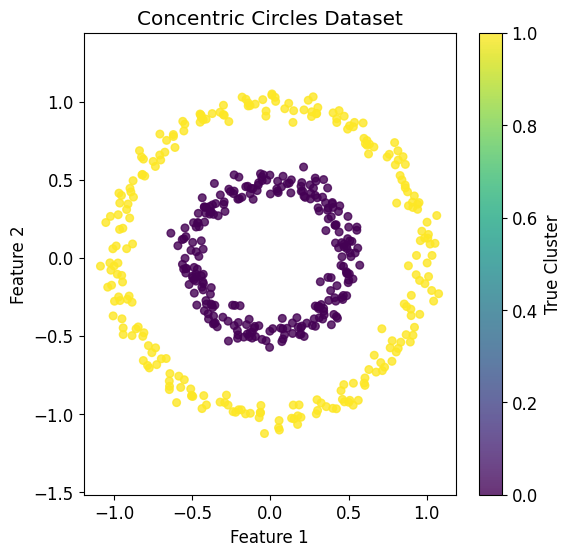

Dataset shape: (500, 2)
Number of clusters: 2


In [7]:
X_circles, y_circles = make_circles(n_samples=500, noise=0.05, factor=0.5)

plt.figure(figsize=(6, 6))
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='viridis', s=30, alpha=0.8)
plt.title("Concentric Circles Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.axis('equal')
plt.colorbar(label='True Cluster')
plt.show()

print(f"Dataset shape: {X_circles.shape}")
print(f"Number of clusters: {len(np.unique(y_circles))}")

### Comprehensive Visualization of Spectral Clustering Process

The following visualization shows all key steps of the spectral clustering algorithm:

/Users/ramipellumbi/paper-club/spectral/src/spectral_clustering.py:44: RuntimeWarning: divide by zero encountered in matmul
  L = np.eye(len(D)) - D_sqrt_inv @ A @ D_sqrt_inv
/Users/ramipellumbi/paper-club/spectral/src/spectral_clustering.py:44: RuntimeWarning: overflow encountered in matmul
  L = np.eye(len(D)) - D_sqrt_inv @ A @ D_sqrt_inv
/Users/ramipellumbi/paper-club/spectral/src/spectral_clustering.py:44: RuntimeWarning: invalid value encountered in matmul
  L = np.eye(len(D)) - D_sqrt_inv @ A @ D_sqrt_inv


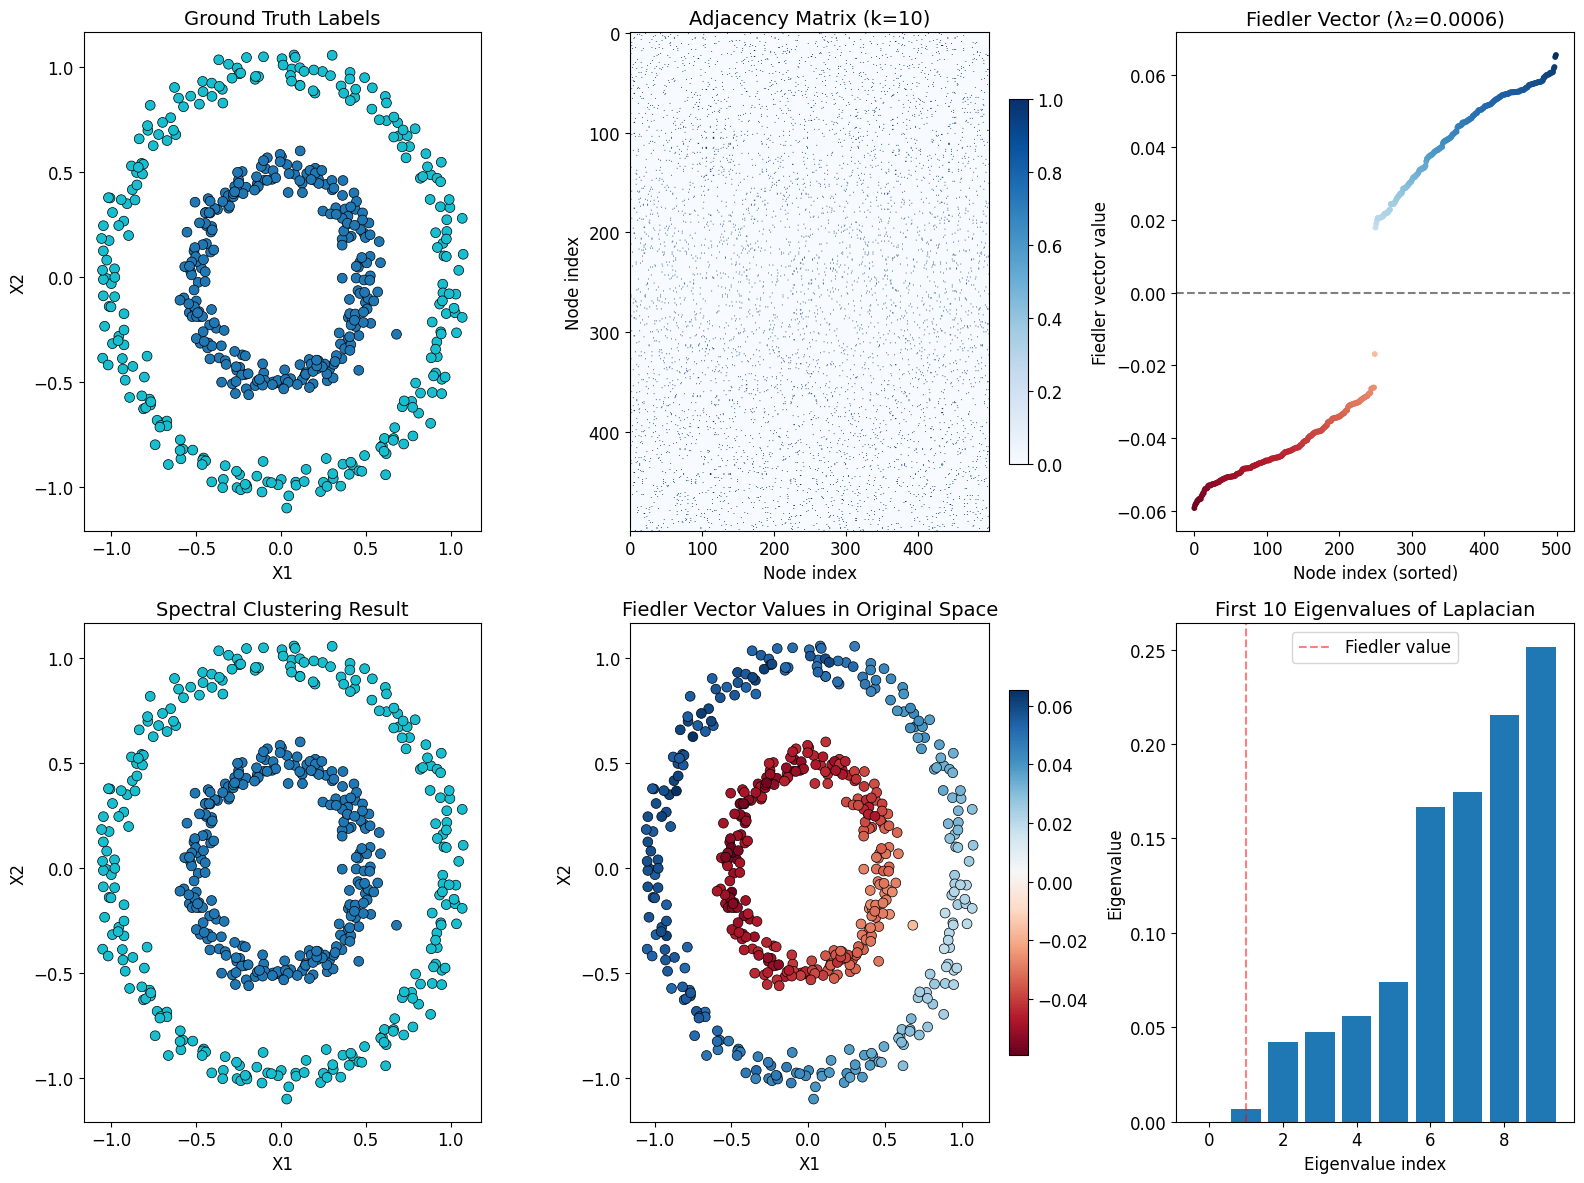

In [5]:
# Visualize the spectral clustering process
fig = visualize_spectral_clustering(X_circles, y_circles, n_neighbors=10)
plt.tight_layout()
plt.show()

### Understanding the Visualizations:

1. **Ground Truth**: Shows the actual cluster labels
2. **Adjacency Matrix**: Visualizes the k-NN graph structure - notice the block diagonal pattern indicating two communities
3. **Fiedler Vector**: The second eigenvector values sorted - shows a clear separation between positive and negative values
4. **Clustering Result**: Final cluster assignments match the ground truth perfectly
5. **Fiedler Vector in Original Space**: Maps the eigenvector values back to the original data points
6. **Eigenvalues**: Shows the spectral gap between $\lambda_2$ and $\lambda_3$, indicating 2 clusters

## Demonstration: Two Moons Dataset

Another classic example where linear boundaries fail:

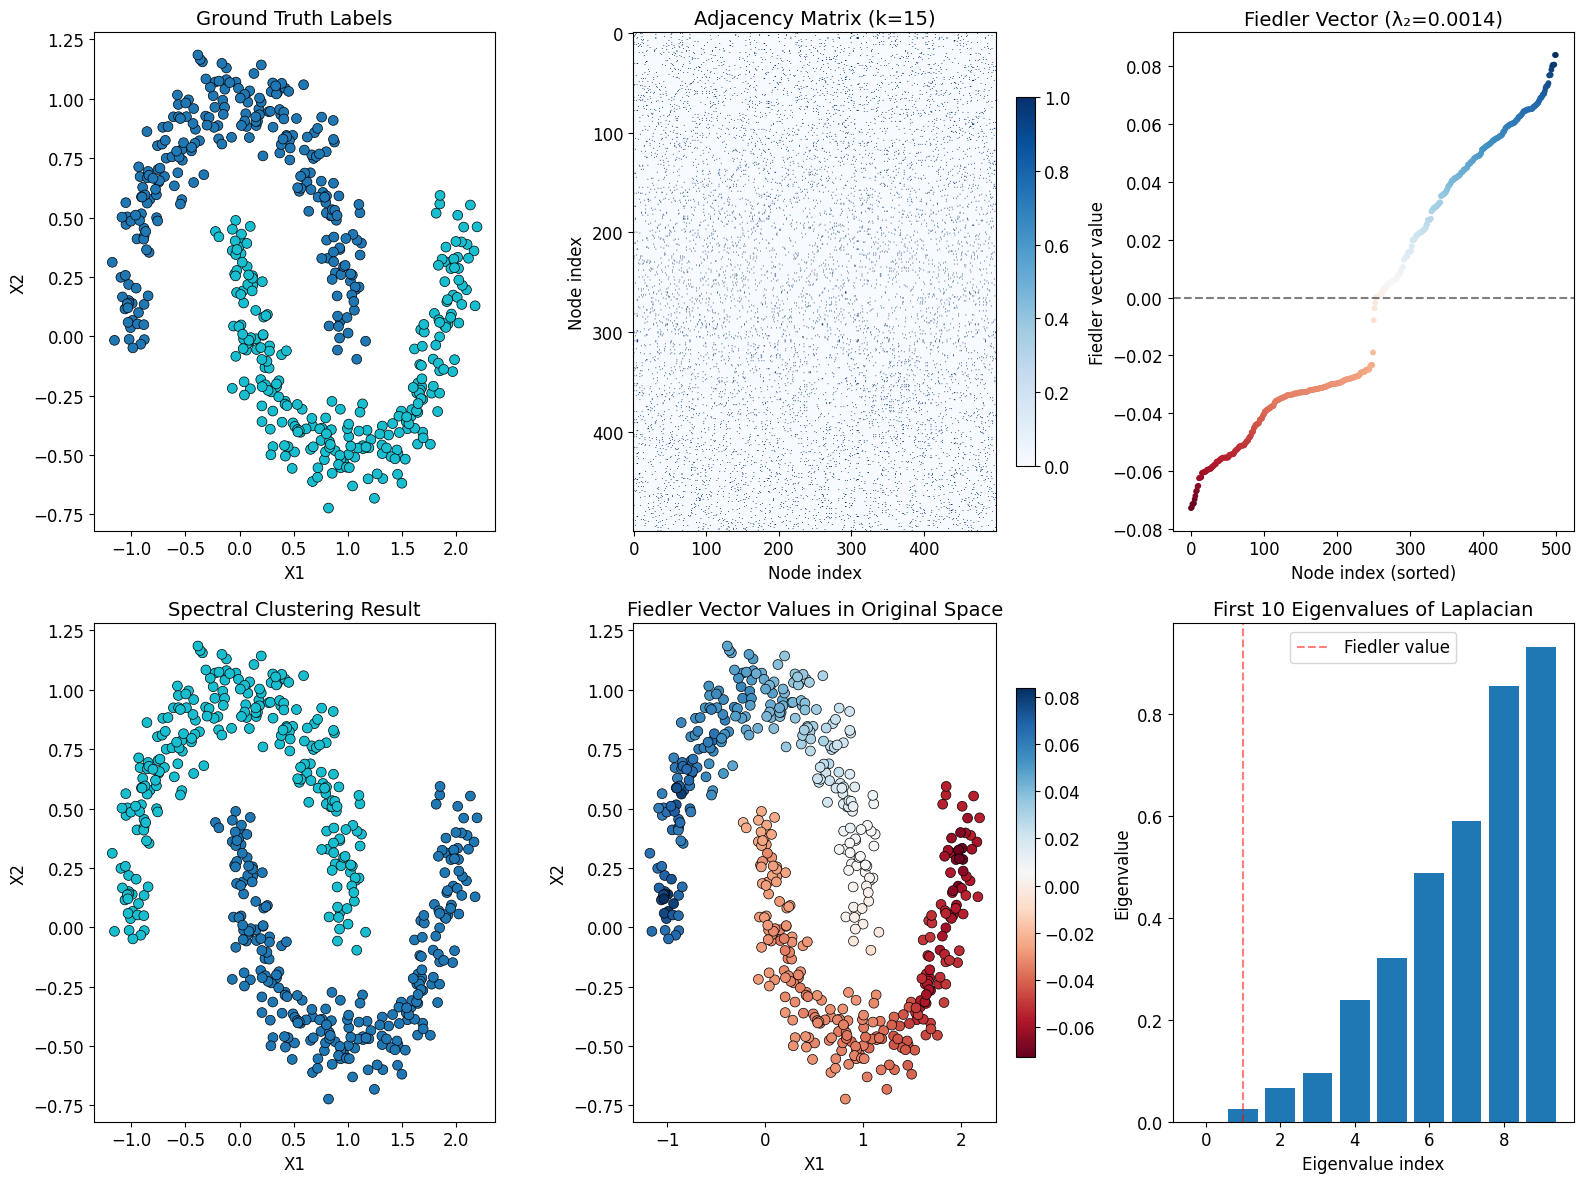

In [6]:
# Generate two moons dataset
X_moons, y_moons = make_moons(n_samples=500, noise=0.1)

# Visualize the spectral clustering process
fig = visualize_spectral_clustering(X_moons, y_moons, n_neighbors=15)
plt.tight_layout()
plt.show()

### Key Observations:

- The Fiedler vector provides excellent separation despite the interleaving crescents
- The eigenvalue spectrum shows a clear gap after the second eigenvalue
- Spectral clustering successfully separates the two moons where k-means would fail

## Parameter Analysis: Normalized vs Unnormalized Laplacian

The choice of Laplacian and the number of neighbors k can significantly impact results:

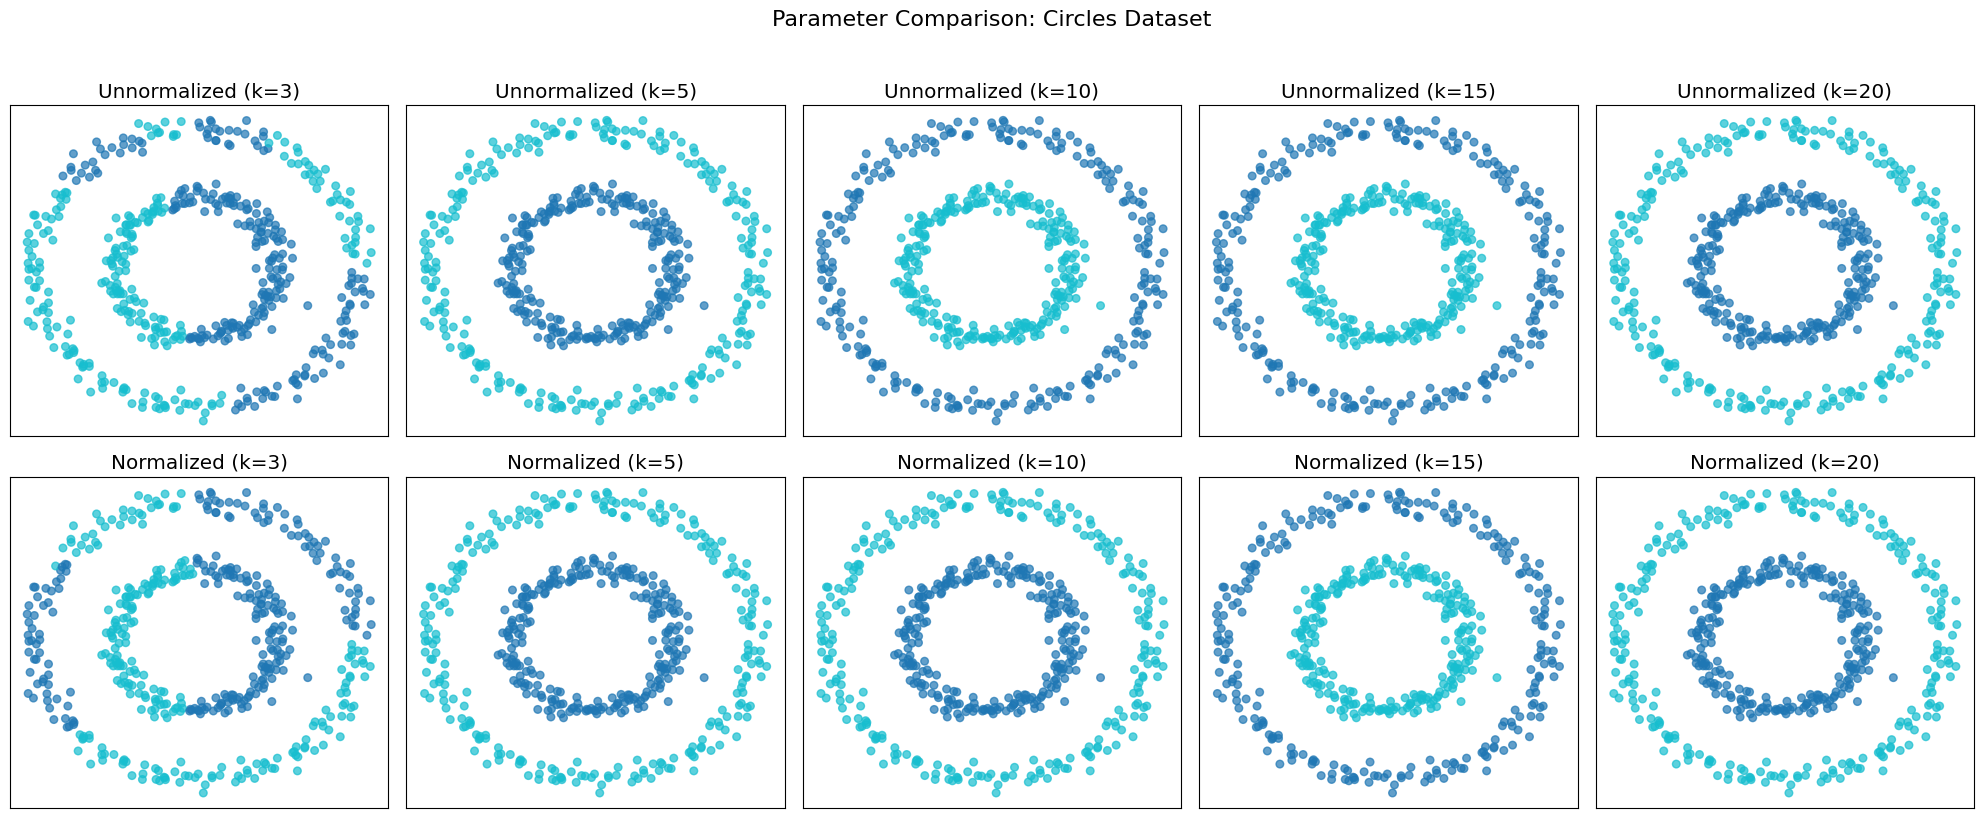

In [7]:
fig_circles = compare_parameters(X_circles, y_circles)
plt.suptitle("Parameter Comparison: Circles Dataset", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

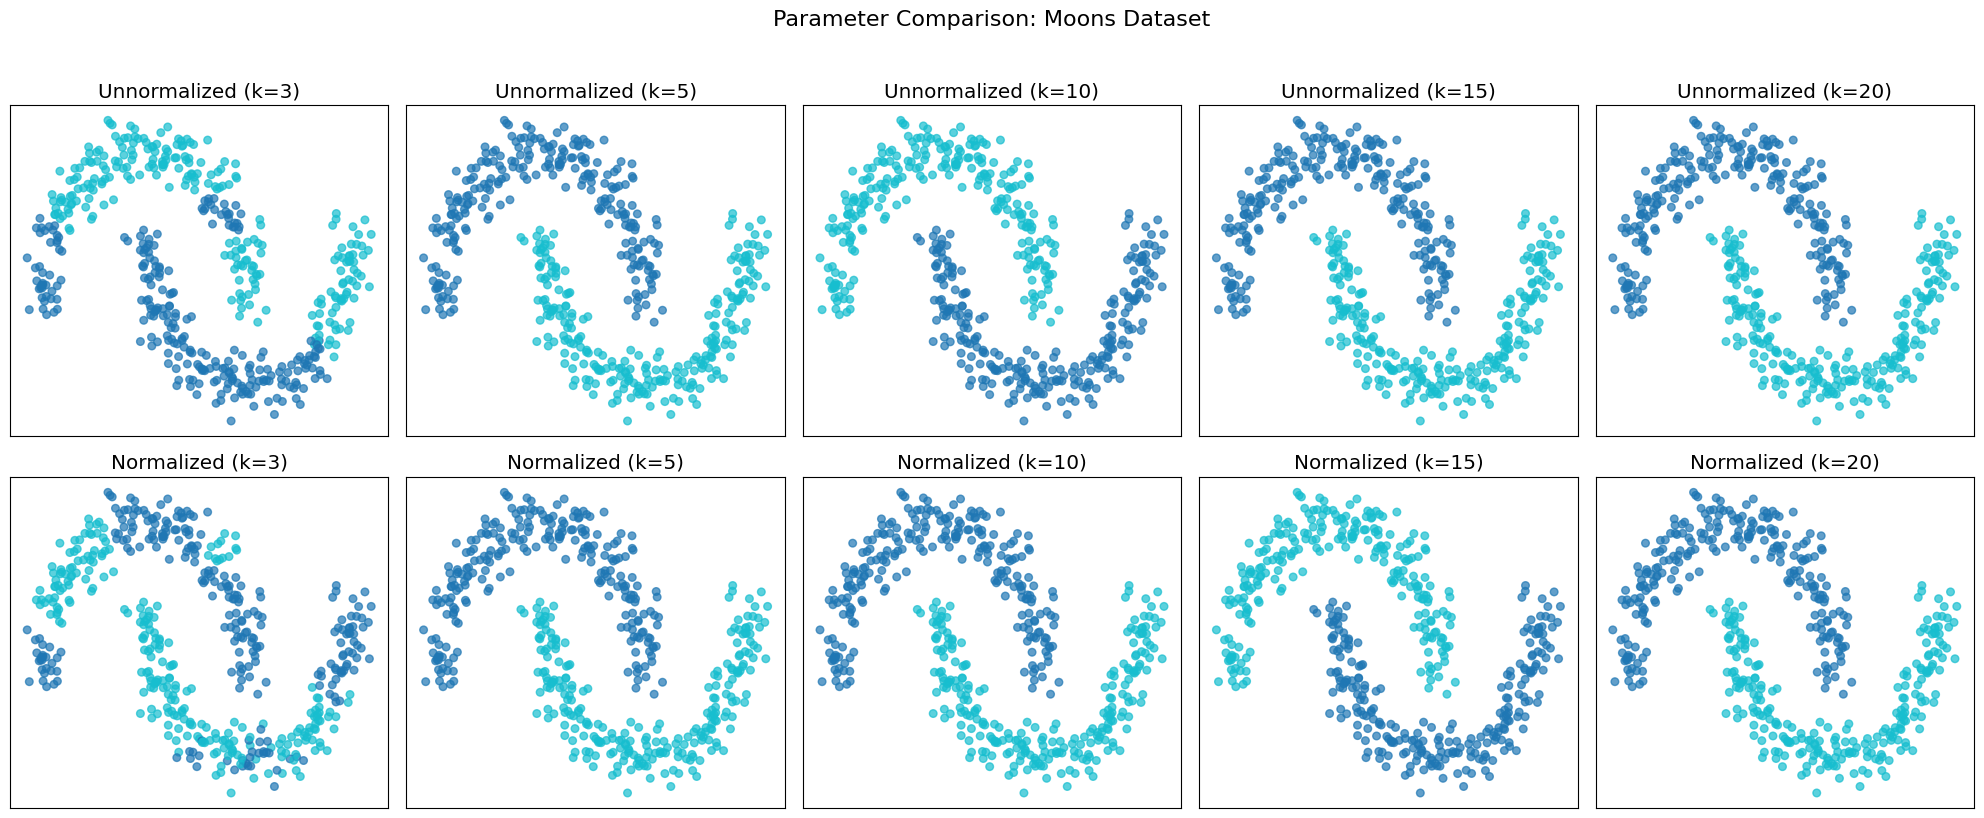

In [8]:
fig_moons = compare_parameters(X_moons, y_moons)
plt.suptitle("Parameter Comparison: Moons Dataset", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

### Parameter Selection Guidelines:

1. **Number of Neighbors (k)**:
   - Too small: Graph may be disconnected
   - Too large: May connect points from different clusters
   - Rule of thumb: Start with $k = \log(n)$ where n is number of points

2. **Normalized vs Unnormalized**:
   - **Normalized Laplacian**: Generally more robust, especially when clusters have different densities
   - **Unnormalized Laplacian**: Can work better when clusters have similar densities
   - In practice, normalized is often preferred

## Comparison with Scikit-learn

Let's validate our implementation against scikit-learn's SpectralClustering:

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score

# Our implementation
our_clusters, _, _ = spectral_clustering_k2(X_circles, n_neighbors=10, use_normalized_laplacian=True)

# Scikit-learn implementation
sklearn_spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', 
                                     n_neighbors=10, random_state=42)
sklearn_clusters = sklearn_spectral.fit_predict(X_circles)

# Compare results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Ground truth
axes[0].scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='viridis', s=30)
axes[0].set_title("Ground Truth")
axes[0].axis('equal')

# Our implementation
axes[1].scatter(X_circles[:, 0], X_circles[:, 1], c=our_clusters, cmap='viridis', s=30)
axes[1].set_title(f"Our Implementation\nARI: {adjusted_rand_score(y_circles, our_clusters):.3f}")
axes[1].axis('equal')

# Sklearn implementation
axes[2].scatter(X_circles[:, 0], X_circles[:, 1], c=sklearn_clusters, cmap='viridis', s=30)
axes[2].set_title(f"Scikit-learn\nARI: {adjusted_rand_score(y_circles, sklearn_clusters):.3f}")
axes[2].axis('equal')

plt.tight_layout()
plt.show()

print(f"Agreement between our implementation and sklearn: {adjusted_rand_score(our_clusters, sklearn_clusters):.3f}")

## Summary and Key Takeaways

### Strengths of Spectral Clustering:

1. **Non-linear Boundaries**: Excels at finding clusters with complex shapes
2. **Theoretical Foundation**: Based on solid graph theory principles
3. **Global Optimization**: Uses global information (eigenvalues) rather than local decisions
4. **Interpretable**: The Fiedler vector provides insight into the clustering structure

### Limitations:

1. **Computational Complexity**: $O(n^3)$ for eigendecomposition (can be improved with approximations)
2. **Parameter Sensitivity**: Performance depends on k (number of neighbors) and graph construction method
3. **Fixed Number of Clusters**: Need to specify k in advance (though eigenvalue gaps can help)
4. **Scalability**: Challenging for very large datasets without approximations

### Practical Tips:

1. **Start with normalized Laplacian** - it's more robust in most cases
2. **Use the eigenvalue spectrum** to determine the number of clusters (look for gaps)
3. **Experiment with different k values** - typically $k \in [\log(n), \sqrt{n}]$
4. **Consider the data structure** - spectral clustering shines when data lies on manifolds

### When to Use Spectral Clustering:

✅ Non-convex cluster shapes  
✅ Data on manifolds  
✅ Image segmentation  
✅ Community detection in networks  
✅ When k-means fails  

❌ Very large datasets (without approximations)  
❌ High-dimensional sparse data  
❌ When linear boundaries suffice (use simpler methods)  

### Extensions and Advanced Topics:

- **Multi-way spectral clustering**: For k > 2, use k eigenvectors and apply k-means
- **Different similarity measures**: Gaussian kernel, adaptive neighbors
- **Approximate methods**: Nyström approximation, power iteration
- **Self-tuning spectral clustering**: Automatic parameter selection
- **Spectral embedding**: Use eigenvectors for visualization and dimensionality reduction